## Abstract
The dataset consists of 5547 breast histology images each of pixel size 50 x 50 x 3. The goal is to classify cancerous images (IDC : invasive ductal carcinoma) vs non-IDC images. In a first step we analyze the images and look at the distribution of the pixel intensities. Then, the images are normalized and we try out some basic classification algorithms like logistic regregession, random forest, decision tree and so on. We validate and compare each of these base models.

After that a neural network is implemented for the classification task.

In [2]:
# Step 1: Import the libraries.
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os
import datetime
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [3]:
# import data

# load images of shape (5547, 50, 50, 3)
x_images = np.load('data/X.npy')

# load labels of shape (5547, 1);
# 0 = no cancer; 1 = cancer
y_images = np.load('data/Y.npy')

In [4]:
# shuffle data
# make a permutation array
perm_array = np.arange(len(x_images))
np.random.shuffle(perm_array)

array([2281, 2140, 5339, ..., 3436, 5239,  201])

In [5]:
# use the permutation array to shuffle images
x_images = x_images[perm_array]
y_images = y_images[perm_array]

# print out some statistics for the dataset
print('x_images.shape =', x_images.shape)
print('x_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images.min(),
                        x_images.mean(), x_images.std(), x_images.max()))

print('')

print('y_images.shape =', y_images.shape)
print('y_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_images.min(),
                        y_images.mean(), y_images.std(), y_images.max()))

x_images.shape = (5547, 50, 50, 3)
x_images.min/mean/std/max = 2.00/185.03/47.25/255.00

y_images.shape = (5547,)
y_images.min/mean/std/max = 0.00/0.50/0.50/1.00


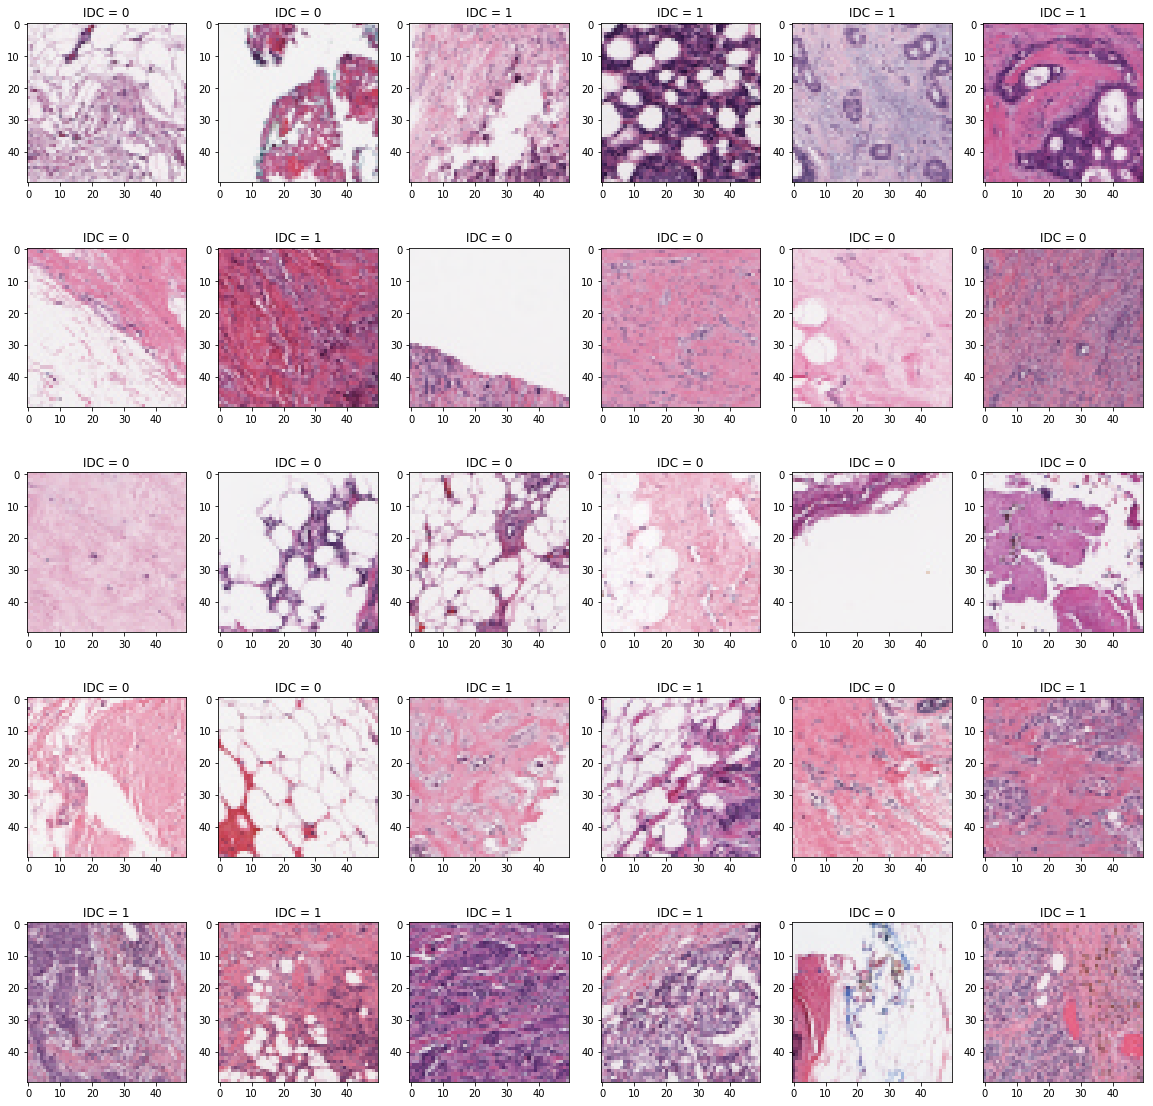

In [6]:
# plot some of the images

imgs_0 = x_images[y_images == 0] # 0 = no cancer
imgs_1 = x_images[y_images == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.title('IDC = %d' %y_images[i])
    plt.imshow(x_images[i])

red channel: min/mean/std/max = 4.00/205.79/36.29/255.00
green channel: min/mean/std/max = 2.00/161.87/53.94/255.00
blue channel: min/mean/std/max = 5.00/187.44/38.69/255.00


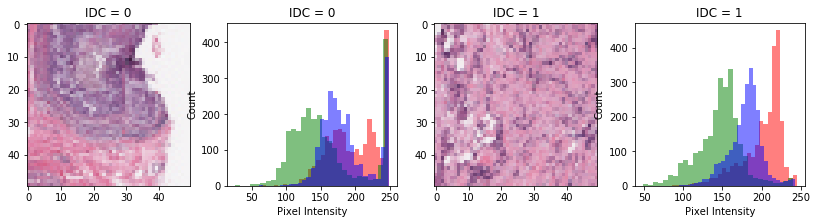

In [7]:
# some statistics for the images
plt.figure(figsize=(14,3))
for i in range(2):
    n_img = np.random.randint(len(x_images))
    plt.subplot(1, 4, 1+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.imshow(x_images[n_img])
    plt.subplot(1, 4, 2+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.ylabel('Count')
    plt.xlabel('Pixel Intensity')
    plt.hist(x_images[n_img,:,:,0].flatten(), bins=30, lw = 0,color='r', alpha=0.5);
    plt.hist(x_images[n_img,:,:,1].flatten(), bins=30, lw = 0, color='g', alpha=0.5);
    plt.hist(x_images[n_img,:,:,2].flatten(), bins=30, lw = 0, color='b', alpha=0.5);
    
print('red channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,0].min(),
    x_images[:,:,:,0].mean(), x_images[:,:,:,0].std(), x_images[:,:,:,0].max()))
print('green channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,1].min(),
    x_images[:,:,:,1].mean(), x_images[:,:,:,1].std(), x_images[:,:,:,1].max()))
print('blue channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,2].min(),
    x_images[:,:,:,2].mean(), x_images[:,:,:,2].std(), x_images[:,:,:,2].max()))

In [8]:
# normalize data

# convert one-hot encodings to labels
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot, 1)

# convert class labels from scalars to one-hot encodings
# 1 => [0, 1]; 0 => [1, 0]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# function to normalize data
def normalize_data(data):
    # convert from [0:255] to [0. : 1.]
    data = data / data.max()
    return data

# normalized training and validation data 
x_train_valid = normalize_data(x_images)

# one-hot encoded labels
y_train_valid = dense_to_one_hot(y_images, 2).astype(np.uint8)

# dictionaries to save the results
y_valid_pred = {}
y_train_pred = {}
y_test_pred = {}
train_loss, valid_loss = {}, {}
train_acc, valid_acc = {}, {}
cnf_valid_matrix = {}

# statistics for normalized images
print('x_train_valid.shape =', x_train_valid.shape)
print('x_train_valid.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_train_valid.min(),
                        x_train_valid.mean(), x_train_valid.std(), x_train_valid.max()))

print('')

print('y_train_valid.shape =', y_train_valid.shape)
print('y_train_valid.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_train_valid.min(),
                        y_train_valid.mean(), y_train_valid.std(), y_train_valid.max()))

x_train_valid.shape = (5547, 50, 50, 3)
x_train_valid.min/mean/std/max = 0.01/0.73/0.19/1.00

y_train_valid.shape = (5547, 2)
y_train_valid.min/mean/std/max = 0.00/0.50/0.50/1.00


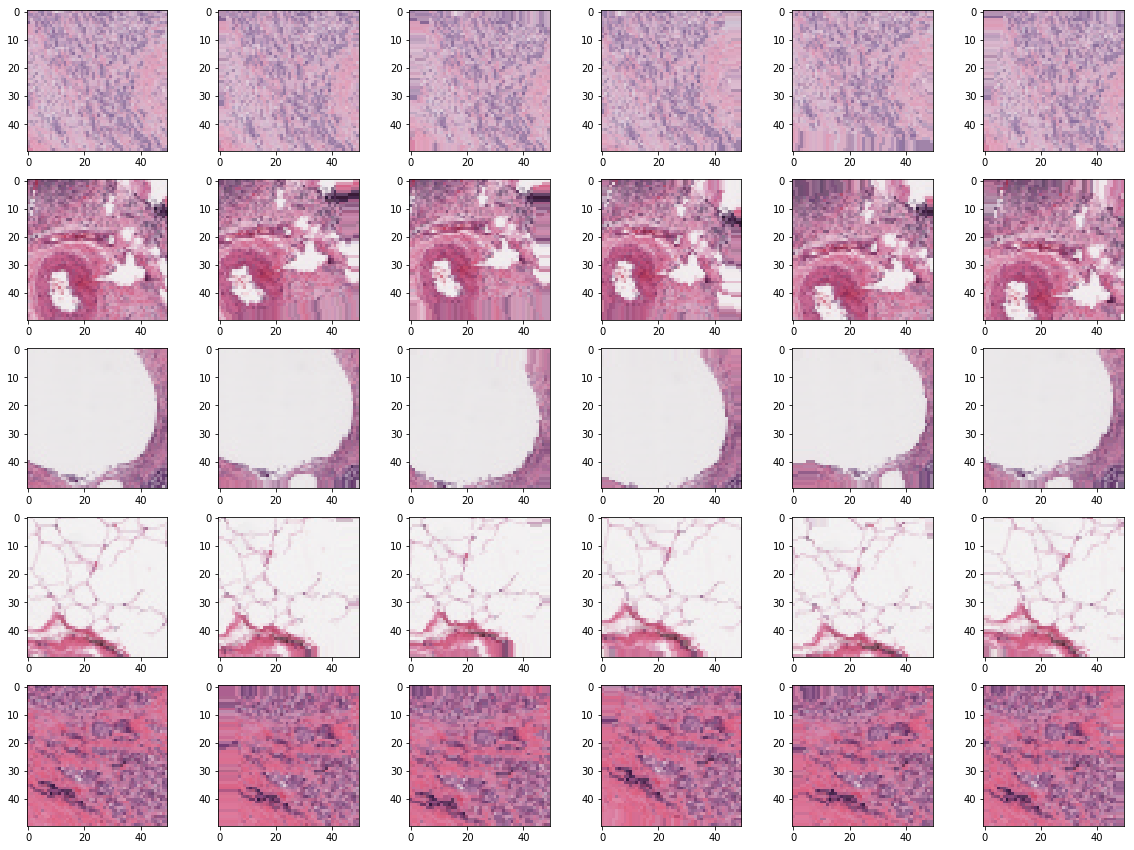

In [9]:
# augment data

# generate new images via rotations, translations, zoom
def generate_images(imgs):
    image_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range = 10,
                                                                  width_shift_range = 0.1,
                                                                  height_shift_range = 0.1, 
                                                                  zoom_range = 0.1)
    
    # get transformed images
    imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)), batch_size=len(imgs), shuffle=False).next()
    return imgs[0]

# check image generation
fig, axs = plt.subplots(5,6,figsize=(20,15))
for i in range(5):
    n = np.random.randint(0, x_images.shape[0]-2)
    axs[i,0].imshow(x_images[n])
    axs[i,1].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,2].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,3].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,4].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,5].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))

In [10]:
## trying out some basic sklearn models

# compute the accuracy of label prediction
def accuracy_from_dense_labels(y_target, y_pred):
    y_target = y_target.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    return np.mean(y_target == y_pred)

logreg = sklearn.linear_model.LogisticRegression(verbose = 0,
                                                solver = 'lbfgs',
                                                multi_class = 'multinomial')

decision_tree = sklearn.tree.DecisionTreeClassifier()

extra_trees = sklearn.ensemble.ExtraTreesClassifier(verbose = 0,
                                                   max_depth = 4)

gradient_boost = sklearn.ensemble.GradientBoostingClassifier(verbose = 0)

random_forest = sklearn.ensemble.RandomForestClassifier(verbose = 0,
                                                       max_depth = 4,
                                                       n_estimators = 10)

gaussianNB = sklearn.naive_bayes.GaussianNB()

# store models in a dictionary

base_models = {'logreg': logreg,
              'extra_trees': extra_trees,
              'gradient_boost': gradient_boost,
              'decision_tree': decision_tree,
              'random_forest': random_forest,
              'gaussianNB': gaussianNB}

# models for out-of-folds predictions

take_models = ['logreg', 'random_forest', 'extra_trees', 'gaussianNB']

for model in take_models:
    train_acc[model] = []
    valid_acc[model] = []
    cnf_valid_matrix[model] = []
    
# start timer
start = datetime.datetime.now()
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')

# cross validation
cv_num = 10
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True)

for i, (train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    # start timer
    start = datetime.datetime.now()
    
    # train and validation data of original images
    x_train = x_train_valid[train_index].reshape(-1,7500)
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index].reshape(-1,7500)
    y_valid = y_train_valid[valid_index]
    
    for mn in take_models:
        
        # create cloned models from base models
        model = sklearn.base.clone(base_models[mn])
        model.fit(x_train, one_hot_to_dense(y_train))
        
        # predictions
        y_train_pred[mn] = model.predict_proba(x_train)
        y_valid_pred[mn] = model.predict_proba(x_valid)
        
        # accuracies
        train_acc[mn].append(accuracy_from_dense_labels(one_hot_to_dense(y_train_pred[mn]),
                                                        one_hot_to_dense(y_train)))
        valid_acc[mn].append(accuracy_from_dense_labels(one_hot_to_dense(y_valid_pred[mn]),
                                                        one_hot_to_dense(y_valid)))
        
        # normalized confusion matrix
        cnf_valid_matrix_tmp = sklearn.metrics.confusion_matrix(
            y_pred = one_hot_to_dense(y_valid_pred[mn]), 
            y_true = one_hot_to_dense(y_valid)).astype(np.float32)
        
        cnf_valid_matrix_tmp[0,:] = cnf_valid_matrix_tmp[0,:]/cnf_valid_matrix_tmp[0,:].sum()
        
        cnf_valid_matrix_tmp[1,:] = cnf_valid_matrix_tmp[1,:]/cnf_valid_matrix_tmp[1,:].sum()
        
        cnf_valid_matrix[mn].append(cnf_valid_matrix_tmp)
        
        print(i,': '+mn+' train/valid accuracy = %.3f/%.3f'%(train_acc[mn][-1], 
                                                             valid_acc[mn][-1]))
        
        
print('running time for training: ', datetime.datetime.now() - start)

print('')

for mn in train_acc.keys():
    print(mn + ' : averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                              np.mean(valid_acc[mn])))


09-03-2018 23:56:45 : start training
0 : logreg train/valid accuracy = 0.846/0.679
0 : random_forest train/valid accuracy = 0.787/0.750
0 : extra_trees train/valid accuracy = 0.773/0.737
0 : gaussianNB train/valid accuracy = 0.717/0.706
1 : logreg train/valid accuracy = 0.833/0.721
1 : random_forest train/valid accuracy = 0.784/0.798
1 : extra_trees train/valid accuracy = 0.769/0.787
1 : gaussianNB train/valid accuracy = 0.711/0.755
2 : logreg train/valid accuracy = 0.832/0.685
2 : random_forest train/valid accuracy = 0.786/0.769
2 : extra_trees train/valid accuracy = 0.772/0.764
2 : gaussianNB train/valid accuracy = 0.715/0.714
3 : logreg train/valid accuracy = 0.846/0.697
3 : random_forest train/valid accuracy = 0.789/0.755
3 : extra_trees train/valid accuracy = 0.772/0.739
3 : gaussianNB train/valid accuracy = 0.715/0.717
4 : logreg train/valid accuracy = 0.857/0.668
4 : random_forest train/valid accuracy = 0.793/0.733
4 : extra_trees train/valid accuracy = 0.774/0.732
4 : gaussianN

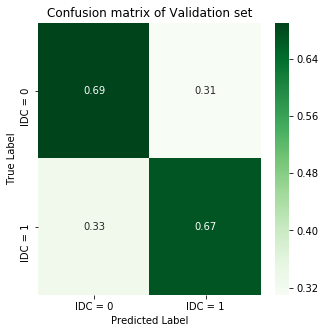

In [11]:
## show confusion matrix of the model
# choose model
model = 'logreg'

# plot
labels_array = ['IDC = 0', 'IDC = 1']
fig, axs = plt.subplots(1, figsize=(5,5))
axs = sns.heatmap(cnf_valid_matrix[model][0], ax=axs, cmap=plt.cm.Greens, annot=True)
axs.set_xticklabels(labels_array)
axs.set_yticklabels(labels_array)
plt.title('Confusion matrix of Validation set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

logreg averaged train/valid accuracy = 0.852/0.689
random_forest averaged train/valid accuracy = 0.787/0.761
extra_trees averaged train/valid accuracy = 0.771/0.757
gaussianNB averaged train/valid accuracy = 0.715/0.715


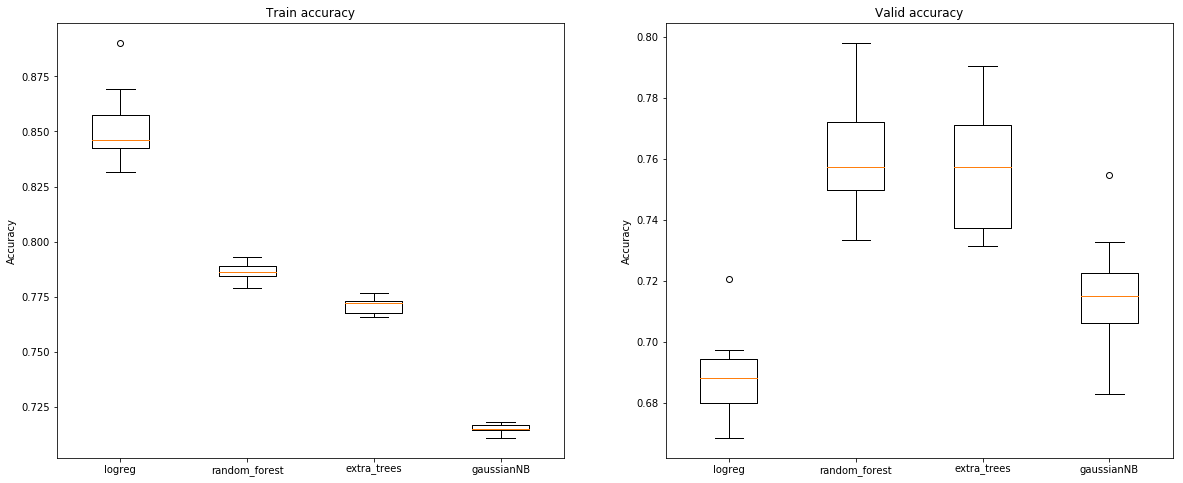

In [12]:
## compare base models

# boxplot comparisons
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
plt.title('Train accuracy')
plt.boxplot([train_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');

ax = fig.add_subplot(1,2,2)
plt.title('Valid accuracy')
plt.boxplot([valid_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');

for mn in train_acc.keys():
    print(mn + ' averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                             np.mean(valid_acc[mn])))

In [22]:
# build a neural network with TensorFlow

# define the neural network class
class nn:
    
    # constructor
    def __init__(self, nn_name='tmp', log_step=0.1, keep_prob=0.33, mb_size=50,
                width=50, height=50, n_channel=3, n_output=2):
        
        # tunable hyperparameters for Neural net architecture
        
        # size of the filter in first convolutional layer
        self.s_f_conv1 = 3
        # number of filters in first conv. layer
        self.n_f_conv1 = 32
        
        # size of the filter in second convolutional layer
        self.s_f_conv2 = 3
        # number of filters in second conv. layer
        self.n_f_conv2 = 32
        
        # size of the filter in third convolutional layer
        self.s_f_conv3 = 3
        # number of filters in third conv. layer
        self.n_f_conv3 = 64
        
        # no. of neurons in first fully connected layer
        self.n_n_fc1 = 576
        
        self.n_channel = n_channel
        self.width = width
        self.height = height
        self.n_output = n_output
        
        # tunable hyperparameters for training process
        # mini batch size
        self.mb_size = mb_size
        # dropout prob
        self.keep_prob = keep_prob
        
        self.learn_rate_array = [10*1e-4, 7.5*1e-4, 5*1e-4, 2.5*1e-4, 1*1e-4, 1*1e-4,
                                 1*1e-4, 0.75*1e-4, 0.5*1e-4, 0.25*1e-4, 0.1*1e-4, 
                                 0.1*1e-4, 0.075*1e-4,0.050*1e-4, 0.025*1e-4, 0.01*1e-4, 
                                 0.0075*1e-4, 0.0050*1e-4,0.0025*1e-4,0.001*1e-4]
        
        self.learn_rate_step_size = 3 # number of epochs
        
        self.learn_rate = self.learn_rate_array[0]
        # position pointing to current learning rate 
        self.learn_rate_pos = 0
        
        self.index_in_epoch = 0
        self.current_epoch = 0
        
        # log results after epochs
        self.log_step = log_step
        # count current number of mini batches trained on
        self.n_log_step = 0
        
        # use tensorboard visualization
        self.use_tb_summary = False
        # use saver to save the model
        self.use_tf_saver = False
        
        self.nn_name = nn_name # name of neural net
        self.perm_array = np.array([]) # permutation array
        
    # function to get the next mini batch
    def next_mini_batch(self):
        start = self.index_in_epoch
        self.index_in_epoch += self.mb_size
        self.current_epoch += self.mb_size/len(self.x_train)
        
        # adapt length of perm array
        if not len(self.perm_array) == len(self.x_train):
            self.perm_array = np.arange(len(self.x_train))
            
        # shuffle once at the start of the epoch
        if start == 0:
            np.random.shuffle(self.perm_array)
            
        # at the end of the epoch
        if self.index_in_epoch > self.x_train.shape[0]:
            #shuffle data
            np.random.shuffle(self.perm_array)
            # start next epoch
            start = 0
            # set index to mini batch size
            self.index_in_epoch = self.mb_size
            
            if self.train_on_augmented_data:
                # use augmented data for next epoch
                self.x_train_aug = normalize_data(self.generate_images(self.x_train))
                self.y_train_aug = self.y_train
                
        end = self.index_in_epoch
        
        if self.train_on_augmented_data:
            # use augmented data
            x_tr = self.x_train_aug[self.perm_array[start:end]]
            y_tr = self.y_train_aug[self.perm_array[start:end]]
            
        else:
            # use original data
            x_tr = self.x_train[self.perm_array[start:end]]
            y_tr = self.y_train[self.perm_array[start:end]]
            
        return x_tr, y_tr
    
    # generate new images via rotations, translations, zoom
    def generate_images(self, imgs):
        print('generate new set of images')
        
        image_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                                      width_shift_range=0.1, 
                                                                      height_shift_range=0.1,
                                                                      zoom_range = 0.1)
        
        # get transformed images
        imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)), batch_size=len(imgs), shuffle=False).next()
        
        return imgs[0]
    
    # weights initialization
    def weight_variable(self, shape, name=None):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name)
    
    # bias initialization
    def bias_variable(self, shape, name=None):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name)
    
    # 2d convolution
    def conv2d(self, x, W, name=None):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME', name=name)
    
    # max pooling
    def maxpool2x2(self, x, name=None):
        return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name=name)
    
    # attach summaries to a tensor for tensorboard visualization
    def summary_variable(self, var, var_name):
        with tf.name_scope(var_name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
            tf.summary.scalar('mean', mean)
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)
            
    # function to create the graph
    def create_graph(self):
        # reset default graph
        tf.reset_default_graph()
        
        # variables for input and output
        self.x_data_tf = tf.placeholder(dtype=tf.float32, shape=[None, self.height, self.width, self.n_channel],
                                        name='x_data_tf')
        self.y_data_tf = tf.placeholder(dtype=tf.float32, shape=[None, self.n_output],
                                        name='y_data_tf')
        
        # layer 1: conv + max-pool
        self.W_conv1_tf = self.weight_variable([self.s_f_conv1, self.s_f_conv1, self.n_channel,
                                                self.n_f_conv1], name='W_conv1_tf') # (3,3,3,32)
        self.b_conv1_tf = self.bias_variable([self.n_f_conv1], name = 'b_conv1_tf') # (32)
        self.h_conv1_tf = tf.nn.relu(self.conv2d(self.x_data_tf, self.W_conv1_tf) 
                                     + self.b_conv1_tf, name = 'h_conv1_tf') # (.,50,50,32)
        self.h_pool1_tf = self.maxpool2x2(self.h_conv1_tf, 
                                            name = 'h_pool1_tf') # (.,25,25,32)
        
        # layer 2: conv + max-pool
        self.W_conv2_tf = self.weight_variable([self.s_f_conv2, self.s_f_conv2, 
                                self.n_f_conv1, self.n_f_conv2], name = 'W_conv2_tf')
        self.b_conv2_tf = self.bias_variable([self.n_f_conv2], name = 'b_conv2_tf')
        self.h_conv2_tf = tf.nn.relu(self.conv2d(self.h_pool1_tf, 
                        self.W_conv2_tf) + self.b_conv2_tf, name ='h_conv2_tf') #(.,25,25,32)
        self.h_pool2_tf = self.maxpool2x2(self.h_conv2_tf, name = 'h_pool2_tf') #(.,13,13,32)
        
        # layer 3: conv + max-pool
        self.W_conv3_tf = self.weight_variable([self.s_f_conv3, self.s_f_conv3, 
                        self.n_f_conv2, self.n_f_conv3], name = 'W_conv3_tf')
        self.b_conv3_tf = self.bias_variable([self.n_f_conv3], name = 'b_conv3_tf')
        self.h_conv3_tf = tf.nn.relu(self.conv2d(self.h_pool2_tf, self.W_conv3_tf) + 
                                     self.b_conv3_tf, name ='h_conv3_tf') #(.,13,13,32)
        self.h_pool3_tf = self.maxpool2x2(self.h_conv3_tf, name='h_pool3_tf') # (.,7,7,64)
        
        # layer 4: fully connected
        self.W_fc1_tf = self.weight_variable([7*7*self.n_f_conv3, self.n_n_fc1], 
                                             name='W_fc1_tf')
        self.b_fc1_tf = self.bias_variable([self.n_n_fc1], name = 'b_fc1_tf')
        self.h_pool3_flat_tf = tf.reshape(self.h_pool3_tf, [-1,7*7*self.n_f_conv3], 
                                          name = 'h_pool3_flat_tf')
        self.h_fc1_tf = tf.nn.relu(tf.matmul(self.h_pool3_flat_tf, 
                           self.W_fc1_tf) + self.b_fc1_tf, name = 'h_fc1_tf')
        
        # add dropout
        self.keep_prob_tf = tf.placeholder(dtype=tf.float32, name = 'keep_prob_tf')
        self.h_fc1_drop_tf = tf.nn.dropout(self.h_fc1_tf, self.keep_prob_tf, 
                                           name = 'h_fc1_drop_tf')
        
        # layer 5: fully connected
        self.W_fc2_tf = self.weight_variable([self.n_n_fc1, self.n_output],
                                             name='W_fc2_tf') # (1024,1)
        self.b_fc2_tf = self.bias_variable([self.n_output], name='b_fc2_tf') # (1024)
        self.z_pred_tf = tf.add(tf.matmul(self.h_fc1_drop_tf, self.W_fc2_tf), 
                                self.b_fc2_tf, name = 'z_pred_tf')
        
        # cost function
        self.cross_entropy_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=self.y_data_tf, logits=self.z_pred_tf), name = 'cross_entropy_tf')
        
        # optimisation function
        self.learn_rate_tf = tf.placeholder(dtype=tf.float32, name="learn_rate_tf")
        self.train_step_tf = tf.train.AdamOptimizer(self.learn_rate_tf).minimize(
            self.cross_entropy_tf, name = 'train_step_tf')
        
        # predicted probabilities in one-hot encoding
        self.y_pred_proba_tf = tf.nn.softmax(self.z_pred_tf, name='y_pred_proba_tf') 
        
        # tensor of correct predictions
        self.y_pred_correct_tf = tf.equal(tf.argmax(self.y_pred_proba_tf, 1),
                                          tf.argmax(self.y_data_tf, 1),
                                          name = 'y_pred_correct_tf')
        
        # accuracy 
        self.accuracy_tf = tf.reduce_mean(tf.cast(self.y_pred_correct_tf, dtype=tf.float32),
                                         name = 'accuracy_tf')
        
        # tensors to save intermediate accuracies and losses during training
        self.train_loss_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                         name='train_loss_tf', validate_shape = False)
        self.valid_loss_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                         name='valid_loss_tf', validate_shape = False)
        self.train_acc_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                        name='train_acc_tf', validate_shape = False)
        self.valid_acc_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                        name='valid_acc_tf', validate_shape = False)
        
        # number of weights and biases
        num_weights = (self.s_f_conv1**2*self.n_f_conv1*self.n_channel
                       + self.s_f_conv2**2*self.n_f_conv1*self.n_f_conv2 
                       + self.s_f_conv3**2*self.n_f_conv2*self.n_f_conv3 
                       + 4*4*self.n_f_conv3*self.n_n_fc1 + self.n_n_fc1*self.n_output)
        num_biases = self.n_f_conv1 + self.n_f_conv2 + self.n_f_conv3 + self.n_n_fc1
        print('num of weights =', num_weights)
        print('num of biases =', num_biases)
        
        return None
    
    def attach_summary(self, sess):
        # create summary tensors for tensorboard
        self.use_tb_summary = True
        self.summary_variable(self.W_conv1_tf, 'W_conv1_tf')
        self.summary_variable(self.b_conv1_tf, 'b_conv1_tf')
        self.summary_variable(self.W_conv2_tf, 'W_conv2_tf')
        self.summary_variable(self.b_conv2_tf, 'b_conv2_tf')
        self.summary_variable(self.W_conv3_tf, 'W_conv3_tf')
        self.summary_variable(self.b_conv3_tf, 'b_conv3_tf')
        self.summary_variable(self.W_fc1_tf, 'W_fc1_tf')
        self.summary_variable(self.b_fc1_tf, 'b_fc1_tf')
        self.summary_variable(self.W_fc2_tf, 'W_fc2_tf')
        self.summary_variable(self.b_fc2_tf, 'b_fc2_tf')
        tf.summary.scalar('cross_entropy_tf', self.cross_entropy_tf)
        tf.summary.scalar('accuracy_tf', self.accuracy_tf)
        
        # merge all summaries for tensorboard
        self.merged = tf.summary.merge_all()

        # initialize summary writer 
        timestamp = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
        filepath = os.path.join(os.getcwd(), 'logs', (self.nn_name+'_'+timestamp))
        self.train_writer = tf.summary.FileWriter(os.path.join(filepath,'train'), sess.graph)
        self.valid_writer = tf.summary.FileWriter(os.path.join(filepath,'valid'), sess.graph)
        
    def attach_saver(self):
        # initialize tensorflow saver
        self.use_tf_saver = True
        self.saver_tf = tf.train.Saver()
        
    # function to train the graph
    def train_graph(self, sess, x_train, y_train, x_valid, y_valid, n_epoch=1,
                    train_on_augmented_data=False):
        
        # train on original or augmented data
        self.train_on_augmented_data = train_on_augmented_data
        
        # training and validation data
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        
        # use augmented data
        if self.train_on_augmented_data:
            print('generate new set of images')
            self.x_train_aug = normalize_data(self.generate_images(self.x_train))
            self.y_train_aug = self.y_train
            
        # parameters
        mb_per_epoch = self.x_train.shape[0]/self.mb_size
        train_loss, train_acc, valid_loss, valid_acc = [],[],[],[]
        
        # start timer
        start = datetime.datetime.now();
        print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')
        print('learnrate =',self.learn_rate,', n_epoch =', n_epoch,
              ', mb_size =', self.mb_size, ', nn_name =', self.nn_name)
        
        # looping over mini batches
        for i in range(int(n_epoch*mb_per_epoch)+1):
            # adapt learning rate
            if not self.learn_rate_pos == int(self.current_epoch // self.learn_rate_step_size):
                self.learn_rate_pos = int(self.current_epoch // self.learn_rate_step_size)
                self.learn_rate = self.learn_rate_array[self.learn_rate_pos]
                print(datetime.datetime.now()-start,': set learn rate to %.6f'%self.learn_rate)
                
            # get new batch
            x_batch, y_batch = self.next_mini_batch()
            
            # run the graph
            sess.run(self.train_step_tf, feed_dict={self.x_data_tf: x_batch, 
                                                    self.y_data_tf: y_batch, 
                                                    self.keep_prob_tf: self.keep_prob, 
                                                    self.learn_rate_tf: self.learn_rate})
            
            # store losses and accuracies
            if i%int(self.log_step*mb_per_epoch) == 0 or i == int(n_epoch*mb_per_epoch):
                self.n_log_step += 1 # for logging the results
                
                feed_dict_train = {
                    self.x_data_tf: self.x_train[self.perm_array[:len(self.x_valid)]], 
                    self.y_data_tf: self.y_train[self.perm_array[:len(self.y_valid)]], 
                    self.keep_prob_tf: 1.0}
                
                feed_dict_valid = {self.x_data_tf: self.x_valid, 
                                   self.y_data_tf: self.y_valid, 
                                   self.keep_prob_tf: 1.0}
                
                # summary for tensorboard
                if self.use_tb_summary:
                    train_summary = sess.run(self.merged, feed_dict = feed_dict_train)
                    valid_summary = sess.run(self.merged, feed_dict = feed_dict_valid)
                    self.train_writer.add_summary(train_summary, self.n_log_step)
                    self.valid_writer.add_summary(valid_summary, self.n_log_step)
                    
                train_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_train))

                train_acc.append(self.accuracy_tf.eval(session = sess, 
                                                       feed_dict = feed_dict_train))
                
                valid_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_valid))
                
                valid_acc.append(self.accuracy_tf.eval(session = sess, 
                                                       feed_dict = feed_dict_valid))

                print('%.2f epoch: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(
                    self.current_epoch, train_loss[-1], valid_loss[-1],
                    train_acc[-1], valid_acc[-1]))
                
        # concatenate losses and accuracies and assign to tensor variables
        tl_c = np.concatenate([self.train_loss_tf.eval(session=sess), train_loss], axis = 0)
        vl_c = np.concatenate([self.valid_loss_tf.eval(session=sess), valid_loss], axis = 0)
        ta_c = np.concatenate([self.train_acc_tf.eval(session=sess), train_acc], axis = 0)
        va_c = np.concatenate([self.valid_acc_tf.eval(session=sess), valid_acc], axis = 0)
        
        sess.run(tf.assign(self.train_loss_tf, tl_c, validate_shape = False))
        sess.run(tf.assign(self.valid_loss_tf, vl_c , validate_shape = False))
        sess.run(tf.assign(self.train_acc_tf, ta_c , validate_shape = False))
        sess.run(tf.assign(self.valid_acc_tf, va_c , validate_shape = False))
        
        print('running time for training: ', datetime.datetime.now() - start)
        return None
    
    # save tensors and summaries
    def save_model(self, sess):
        # tf saver
        if self.use_tf_saver:
            # filepath = os.path.join(os.getcwd(),'logs',self.nn_name)
            filepath = os.path.join(os.getcwd(), self.nn_name)
            self.saver_tf.save(sess, filepath)
            
        # tb summary
        if self.use_tb_summary:
            self.train_writer.close()
            self.valid_writer.close()
            
        return None
    
    # forward prediction of the current graph
    def forward(self, sess, x_data):
        y_pred_proba = self.y_pred_proba_tf.eval(session = sess, 
                                                 feed_dict = {self.x_data_tf: x_data,
                                                              self.keep_prob_tf: 1.0})
        
        return y_pred_proba
    
    # function to load tensors from a saved graph
    def load_tensors(self, graph):
        # input tensors
        self.x_data_tf = graph.get_tensor_by_name("x_data_tf:0")
        self.y_data_tf = graph.get_tensor_by_name("y_data_tf:0")
        
        # weights and bias tensors
        self.W_conv1_tf = graph.get_tensor_by_name("W_conv1_tf:0")
        self.W_conv2_tf = graph.get_tensor_by_name("W_conv2_tf:0")
        self.W_conv3_tf = graph.get_tensor_by_name("W_conv3_tf:0")
        self.W_fc1_tf = graph.get_tensor_by_name("W_fc1_tf:0")
        self.W_fc2_tf = graph.get_tensor_by_name("W_fc2_tf:0")
        self.b_conv1_tf = graph.get_tensor_by_name("b_conv1_tf:0")
        self.b_conv2_tf = graph.get_tensor_by_name("b_conv2_tf:0")
        self.b_conv3_tf = graph.get_tensor_by_name("b_conv3_tf:0")
        self.b_fc1_tf = graph.get_tensor_by_name("b_fc1_tf:0")
        self.b_fc2_tf = graph.get_tensor_by_name("b_fc2_tf:0")
        
        # activation tensors
        self.h_conv1_tf = graph.get_tensor_by_name('h_conv1_tf:0')  
        self.h_pool1_tf = graph.get_tensor_by_name('h_pool1_tf:0')
        self.h_conv2_tf = graph.get_tensor_by_name('h_conv2_tf:0')
        self.h_pool2_tf = graph.get_tensor_by_name('h_pool2_tf:0')
        self.h_conv3_tf = graph.get_tensor_by_name('h_conv3_tf:0')
        self.h_pool3_tf = graph.get_tensor_by_name('h_pool3_tf:0')
        self.h_fc1_tf = graph.get_tensor_by_name('h_fc1_tf:0')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        
        self.learn_rate_tf = graph.get_tensor_by_name("learn_rate_tf:0")
        self.keep_prob_tf = graph.get_tensor_by_name("keep_prob_tf:0")
        self.cross_entropy_tf = graph.get_tensor_by_name('cross_entropy_tf:0')
        self.train_step_tf = graph.get_operation_by_name('train_step_tf')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        self.y_pred_proba_tf = graph.get_tensor_by_name("y_pred_proba_tf:0")
        self.y_pred_correct_tf = graph.get_tensor_by_name('y_pred_correct_tf:0')
        self.accuracy_tf = graph.get_tensor_by_name('accuracy_tf:0')
        
        # tensor of stored losses and accuricies during training
        self.train_loss_tf = graph.get_tensor_by_name("train_loss_tf:0")
        self.train_acc_tf = graph.get_tensor_by_name("train_acc_tf:0")
        self.valid_loss_tf = graph.get_tensor_by_name("valid_loss_tf:0")
        self.valid_acc_tf = graph.get_tensor_by_name("valid_acc_tf:0")
        
        return None
    
    # get losses of training and validation sets
    def get_loss(self, sess):
        train_loss = self.train_loss_tf.eval(session=sess)
        valid_loss = self.valid_loss_tf.eval(session=sess)
        return train_loss, valid_loss
    
    # get accuracies of training and validation sets
    def get_accuracy(self, sess):
        train_acc = self.train_acc_tf.eval(session=sess)
        valid_acc = self.valid_acc_tf.eval(session=sess)
        return train_acc, valid_acc
    
    # get weights
    def get_weights(self, sess):
        W_conv1 = self.W_conv1_tf.eval(session = sess)
        W_conv2 = self.W_conv2_tf.eval(session = sess)
        W_conv3 = self.W_conv3_tf.eval(session = sess)
        W_fc1_tf = self.W_fc1_tf.eval(session = sess)
        W_fc2_tf = self.W_fc2_tf.eval(session = sess)
        return W_conv1, W_conv2, W_conv3, W_fc1_tf, W_fc2_tf
    
    # get biases
    def get_biases(self, sess):
        b_conv1 = self.b_conv1_tf.eval(session = sess)
        b_conv2 = self.b_conv2_tf.eval(session = sess)
        b_conv3 = self.b_conv3_tf.eval(session = sess)
        b_fc1_tf = self.b_fc1_tf.eval(session = sess)
        b_fc2_tf = self.b_fc2_tf.eval(session = sess)
        return b_conv1, b_conv2, b_conv3, b_fc1_tf, b_fc2_tf
    
    # load session from file, restore graph, load tensors
    def load_session_from_file(self, filename):
        tf.reset_default_graph()
        filepath = os.path.join(os.getcwd(), filename+'.meta')
        saver = tf.train.import_meta_graph(filepath)
        print(filepath)
        sess = tf.Session()
        saver.restore(sess, mn)
        graph = tf.get_default_graph()
        self.load_tensors(graph)
        return sess
    
    # receive activations given the input
    def get_activations(self, sess, x_data):
        feed_dict = {self.x_data_tf: x_data, self.keep_prob_tf: 1.0}
        h_conv1 = self.h_conv1_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool1 = self.h_pool1_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv2 = self.h_conv2_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool2 = self.h_pool2_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv3 = self.h_conv3_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool3 = self.h_pool3_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc1 = self.h_fc1_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc2 = self.z_pred_tf.eval(session = sess, feed_dict = feed_dict)
        return h_conv1,h_pool1,h_conv2,h_pool2,h_conv3,h_pool3,h_fc1,h_fc2

In [18]:
# train the neural network graph
nn_name = ['nn0','nn1','nn2','nn3','nn4','nn5','nn6','nn7','nn8','nn9']

# cross validation
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    # start timer
    start = datetime.datetime.now();
    
    # train and validation data of original images
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]
    
    # create neural network graph
    nn_graph = nn(nn_name = nn_name[i]) # instance of nn_class
    nn_graph.create_graph() # create graph
    nn_graph.attach_saver() # attach saver tensors
    
    # start tensorflow session
    with tf.Session() as sess:
        
        # attach summaries
        nn_graph.attach_summary(sess) 
        
        # variable initialization of the default graph
        sess.run(tf.global_variables_initializer()) 
    
        # training on original data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 1.)
        
        # training on augmented data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 29.,
                             train_on_augmented_data = True)

        # save tensors and summaries of model
        nn_graph.save_model(sess)
    
    break
    
print('total running time for training: ', datetime.datetime.now() - start)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

num of weights = 619488
num of biases = 704
10-03-2018 01:42:58 : start training
learnrate = 0.001 , n_epoch = 1.0 , mb_size = 50 , nn_name = nn0
0.01 epoch: train/val loss = 5.7118/5.3686, train/val acc = 0.4865/0.5207
0.10 epoch: train/val loss = 0.7349/0.7775, train/val acc = 0.5135/0.4793
0.19 epoch: train/val loss = 0.6987/0.6796, train/val acc = 0.5009/0.5387
0.28 epoch: train/val loss = 0.6328/0.6479, train/val acc = 0.6505/0.6360
0.37 epoch: train/val loss = 0.6005/0.6107, train/val acc = 0.7153/0.7117
0.46 epoch: train/val loss = 0.6578/0.6301, train/val acc = 0.6108/0.6523
0.55 epoch: train/val loss = 0.6871/0.6559, train/val acc = 0.6144/0.6306
0.64 epoch: train/val loss = 0.5559/0.5540, train/val acc = 0.7423/0.7333
0.73 epoch: train/val loss = 0.5545/0.5549, train/val acc = 0.7369/0.7333

8.76 epoch: train/val loss = 0.4350/0.4731, train/val acc = 0.8000/0.7820
8.85 epoch: train/val loss = 0.4344/0.4667, train/val acc = 0.8162/0.7748
generate new set of images
8.94 epoch: train/val loss = 0.5027/0.4873, train/val acc = 0.7514/0.7766
0:14:19.186626 : set learn rate to 0.000250
9.03 epoch: train/val loss = 0.5049/0.4952, train/val acc = 0.7550/0.7748
9.12 epoch: train/val loss = 0.5016/0.4758, train/val acc = 0.7694/0.7640
9.21 epoch: train/val loss = 0.4929/0.4752, train/val acc = 0.7514/0.7802
9.30 epoch: train/val loss = 0.5215/0.4870, train/val acc = 0.7550/0.7640
9.40 epoch: train/val loss = 0.4962/0.4804, train/val acc = 0.7514/0.7748
9.49 epoch: train/val loss = 0.5032/0.4718, train/val acc = 0.7586/0.7712
9.58 epoch: train/val loss = 0.4943/0.4731, train/val acc = 0.7532/0.7784
9.67 epoch: train/val loss = 0.5017/0.4688, train/val acc = 0.7604/0.7694
9.76 epoch: train/val loss = 0.4962/0.4641, train/val acc = 0.7586/0.7856
9.85 epoch: train/val loss = 0.4970/0.471

18.14 epoch: train/val loss = 0.4872/0.4565, train/val acc = 0.7766/0.7802
18.23 epoch: train/val loss = 0.5036/0.4639, train/val acc = 0.7604/0.7874
18.32 epoch: train/val loss = 0.4908/0.4568, train/val acc = 0.7802/0.7802
18.41 epoch: train/val loss = 0.4888/0.4557, train/val acc = 0.7820/0.7802
18.50 epoch: train/val loss = 0.4865/0.4551, train/val acc = 0.7766/0.7766
18.59 epoch: train/val loss = 0.4921/0.4743, train/val acc = 0.7784/0.7694
18.68 epoch: train/val loss = 0.5007/0.4635, train/val acc = 0.7622/0.7874
18.77 epoch: train/val loss = 0.4846/0.4569, train/val acc = 0.7712/0.7820
generate new set of images
18.86 epoch: train/val loss = 0.4457/0.4568, train/val acc = 0.8000/0.7766
18.95 epoch: train/val loss = 0.4450/0.4564, train/val acc = 0.8000/0.7748
19.04 epoch: train/val loss = 0.4506/0.4659, train/val acc = 0.7982/0.7712
19.13 epoch: train/val loss = 0.4575/0.4685, train/val acc = 0.7892/0.7892
19.22 epoch: train/val loss = 0.4430/0.4579, train/val acc = 0.8000/0.785

27.60 epoch: train/val loss = 0.4479/0.4557, train/val acc = 0.8000/0.7838
27.69 epoch: train/val loss = 0.4449/0.4528, train/val acc = 0.8018/0.7784
generate new set of images
27.78 epoch: train/val loss = 0.4637/0.4512, train/val acc = 0.7784/0.7802
27.87 epoch: train/val loss = 0.4634/0.4517, train/val acc = 0.7784/0.7784
27.96 epoch: train/val loss = 0.4632/0.4513, train/val acc = 0.7802/0.7820
28.05 epoch: train/val loss = 0.4638/0.4515, train/val acc = 0.7784/0.7766
28.15 epoch: train/val loss = 0.4635/0.4526, train/val acc = 0.7802/0.7802
28.24 epoch: train/val loss = 0.4648/0.4548, train/val acc = 0.7730/0.7838
28.33 epoch: train/val loss = 0.4633/0.4521, train/val acc = 0.7766/0.7802
28.42 epoch: train/val loss = 0.4650/0.4523, train/val acc = 0.7820/0.7820
28.51 epoch: train/val loss = 0.4661/0.4528, train/val acc = 0.7802/0.7748
28.60 epoch: train/val loss = 0.4638/0.4519, train/val acc = 0.7748/0.7784
28.69 epoch: train/val loss = 0.4638/0.4514, train/val acc = 0.7766/0.778

In [19]:
## visualization with tensorboard
if False:
    !tensorboard --logdir=./logs

C:\Users\Shreyash Soni\wd\breast-histology-image-classification\nn0.meta
INFO:tensorflow:Restoring parameters from nn0
final train/valid loss = 0.4641/0.4526, train/valid accuracy = 0.7802/0.7766


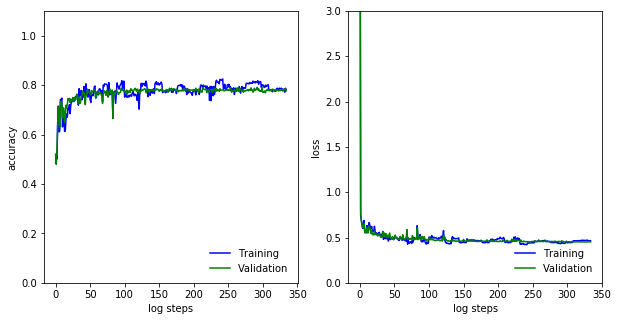

In [23]:
## loss and accuracy curves

# choose neural network
mn = nn_name[0]
nn_graph = nn()
sess = nn_graph.load_session_from_file(mn)
train_loss[mn], valid_loss[mn] = nn_graph.get_loss(sess)
train_acc[mn], valid_acc[mn] = nn_graph.get_accuracy(sess)
sess.close()

print('final train/valid loss = %.4f/%.4f, train/valid accuracy = %.4f/%.4f'%(
    train_loss[mn][-1], valid_loss[mn][-1], train_acc[mn][-1], valid_acc[mn][-1]))

plt.figure(figsize=(10, 5));
plt.subplot(1,2,1);
plt.plot(np.arange(0,len(train_acc[mn])), train_acc[mn],'-b', label='Training')
plt.plot(np.arange(0,len(valid_acc[mn])), valid_acc[mn],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.0)
plt.ylabel('accuracy')
plt.xlabel('log steps');

plt.subplot(1,2,2)
plt.plot(np.arange(0,len(train_loss[mn])), train_loss[mn],'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss[mn])), valid_loss[mn],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 3.0, ymin = 0.0)
plt.ylabel('loss')
plt.xlabel('log steps');

C:\Users\Shreyash Soni\wd\breast-histology-image-classification\nn0.meta
INFO:tensorflow:Restoring parameters from nn0


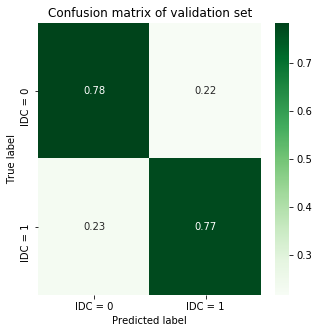

In [24]:
## show confusion matrix

# choose neural network
mn = nn_name[0]
nn_graph = nn()
sess = nn_graph.load_session_from_file(mn)
y_valid_pred[mn] = nn_graph.forward(sess, x_valid)
sess.close()

# confusion matrix
cnf_valid_matrix['neural_network'] = sklearn.metrics.confusion_matrix(
    y_pred = one_hot_to_dense(y_valid_pred[mn]), 
    y_true = one_hot_to_dense(y_valid)).astype(np.float32)

# normalize
cnf_valid_matrix['neural_network'][0,:] = cnf_valid_matrix['neural_network'][0,:]/cnf_valid_matrix['neural_network'][0,:].sum()  
cnf_valid_matrix['neural_network'][1,:] = cnf_valid_matrix['neural_network'][1,:]/cnf_valid_matrix['neural_network'][1,:].sum()  

# plot
labels_array = ['IDC = 0', 'IDC = 1']
fig, ax = plt.subplots(1,figsize=(5,5))
ax = sns.heatmap(cnf_valid_matrix['neural_network'], ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();